In [1]:
import numpy as np
from scipy.linalg import qr
from scipy.linalg import svdvals
from scipy.linalg import pinv
from scipy.linalg.interpolative import interp_decomp
from matplotlib import pyplot as plt
import scipy.linalg.interpolative as sli
import scipy
import scipy.linalg 
import math
import time
plt.rcParams['figure.figsize'] = [10, 8]

%matplotlib inline

In [15]:
import numpy as np
n = 2000
x = np.linspace(-1, 1, n)
eps = 0.1

def fun(x, y):
    """Evaluate a kernel function on a tensor grid"""
    xx = x.reshape(n,1)
    yy = y.reshape(1,n)
    return 1./(eps + np.abs(xx-yy))

A = fun(x, x)
nboxes = 40
size = n // nboxes

In [3]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [4]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [21]:
def plot_box_ranks(A, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, A, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    print(ranks)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

[[50  6  5 ...  3  3  3]
 [ 6 50  6 ...  3  3  3]
 [ 5  6 50 ...  3  3  3]
 ...
 [ 3  3  3 ... 50  6  5]
 [ 3  3  3 ...  6 50  6]
 [ 3  3  3 ...  5  6 50]]


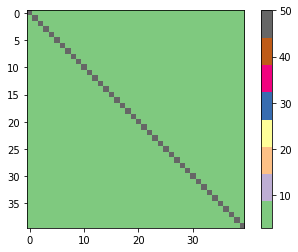

In [22]:
plot_box_ranks(A,nboxes,n)

#### Construct $L_{i}$ and the index set from each $L_{i}$. Then using the index set to construct the matrix $S$ where $A = D + LSR$

In [24]:
def L(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [25]:
def index_set(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,A,nboxes,n)[1][0:k])
    return l

In [26]:
def SSS(k,A,nboxes,n):
    ll = index_set(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [27]:
def R(i,k,A,nboxes,n):
    RR = np.transpose(L(i,k,A,nboxes,n)[0])
    return RR

In [28]:
mat_D = np.zeros((n,n))
for i in range (nboxes):
    mat_D[i*size : (i + 1)*size, i*size : (i + 1)*size] = get_box(i,i,A,nboxes,n)

In [10]:
def mat_L(k,A,nboxes,n): 
    matrix_= np.zeros((n, k*nboxes))
    for i in range(nboxes):
        matrix_[i*size : (i + 1)*size, i*k : (i + 1)*k] = L(i,k,A,nboxes,n)[0]
    return matrix_

In [11]:
def mat_R(k,A,nboxes,n): 
    matrix_= np.zeros((k*nboxes, n))
    for i in range(nboxes):
        matrix_[i*k : (i + 1)*k, i*size : (i + 1)*size] = R(i,k,A,nboxes,n)
    return matrix_

#### Compute the exact value of $\log\det(A)$

In [33]:
_,L1,U1 = scipy.linalg.lu(A)

logdet = 0
for i in range(n):
    logdet += math.log(U1[i,i])
print (logdet)

-3245.3450592397726


#### Compute the approximation value by directly calculating the $LU$ decomposition of $\tilde{A} = 
\begin{bmatrix}
    D & L & 0 \\
    R & 0 & -I \\
    0 & -I & S
\end{bmatrix}$

In [13]:
def mat2(k,A,nboxes,n):
    matrix_ = np.block([
        [mat_D,                mat_L(k,A,nboxes,n),             np.zeros((n,k*nboxes))],
        [mat_R(k,A,nboxes,n),  np.zeros((k*nboxes,k*nboxes)),     -np.identity(k*nboxes)],
        [np.zeros((k*nboxes,n)), -np.identity(k*nboxes), SSS(k,A,nboxes,n) ]
    ])
    return matrix_

In [14]:
def logdet_mat2(k,A,nboxes,n):
    __,l,u = scipy.linalg.lu(mat2(k,A,nboxes,n))
    det = 0
    for i in range(n+2*k*nboxes):
        det +=math.log(abs(u[i,i])) 
    return det

start2 = time.time()
print (logdet_mat2(size,A,nboxes,n))
end2 = time.time()
running_time = end2-start2
print("The running time is %f when we set the rank k to be %f" %(running_time,size))

-3245.34505923978
The running time is 2.852015 when we set the rank k to be 50.000000


In [17]:
"""The list of the approximation value with different rank we set."""
l_logdet_mat2 = []
for i in range(1,size+1):
    l_logdet_mat2.append(logdet_mat2(i,A,nboxes,n))

#### Plot these values with the exact value

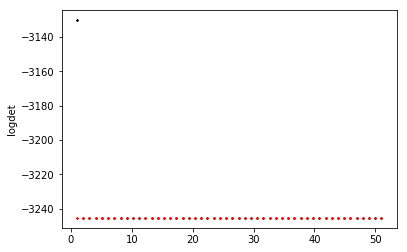

In [16]:
k_det = np.linspace(1,size+1,size)

l_det2 = []
for i in range(size):
    l_det2.append(logdet)

plt.plot(k_det,l_logdet_mat2,'k*',markersize=2)
plt.plot(k_det,l_det2,'r*',markersize=2)

plt.ylabel('logdet') 
plt.show()

#### Plot the relative error

In [63]:
relative_error = []
for i in range(size):
    a = (l_logdet_mat2[i] - logdet)/logdet
    b = abs(a)
    if b == 0:
        relative_error.append(-16)
    else: 
        relative_error.append(np.log10(b))

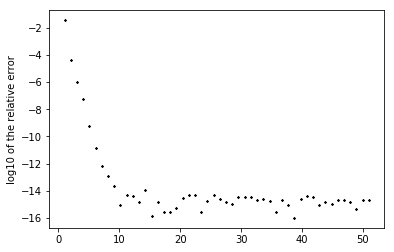

In [64]:
k_det = np.linspace(1,size+1,size)
plt.plot(k_det,relative_error,'k*',markersize=2)
plt.ylabel('log10 of the relative error') 
plt.show()

#### Method 2

#### Construct the structured matrix and its LU decomposition
$\tilde{A} = 
\begin{bmatrix}
    D & L & 0 \\
    R & 0 & -I \\
    0 & -I & S
\end{bmatrix}
= \begin{bmatrix}
    I & 0 & 0 \\
    RD^{-1} & I & 0 \\
    0 & (RD^{-1}L)^{-1} & I
\end{bmatrix}  \begin{bmatrix}
    D & L & 0 \\
    0 & -RD^{-1}L & -I \\
    0 & 0 & S+(RD^{-1}L)^{-1}
\end{bmatrix}$


#### Construct $S+(RD^{-1}L)^{-1}$ first

In [29]:
def new_S(k,A,nboxes,n):
    mat_ = SSS(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat_

In [30]:
def logdet_method2(k,A,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [38]:
start3 = time.time()
print (logdet_method2(size,A,nboxes,n))
end3 = time.time()
running_time3 = end3-start3
print("The running time is %f when we set the rank k to be %f" %(running_time3,size))

-3245.3450592398513
The running time is 3.002485 when we set the rank k to be 50.000000


In [31]:
"""The list of the approximation value with different rank we set."""
l_logdet_method2 = []
for i in range(1,size+1):
    l_logdet_method2.append(logdet_method2(i,A,nboxes,n))

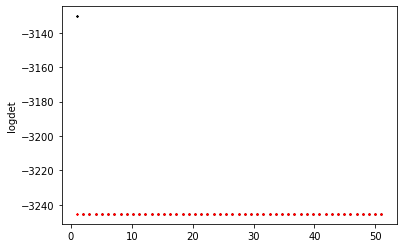

In [34]:
k_det = np.linspace(1,size+1,size)

l_det2 = []
for i in range(size):
    l_det2.append(logdet)

plt.plot(k_det,l_logdet_method2,'k*',markersize=2)
plt.plot(k_det,l_det2,'r*',markersize=2)

plt.ylabel('logdet') 
plt.show()

In [35]:
relative_error_2 = []
for i in range(size):
    a = (l_logdet_method2[i] - logdet)/logdet
    b = abs(a)
    if b == 0:
        relative_error_2.append(-16)
    else: 
        relative_error_2.append(np.log10(b))

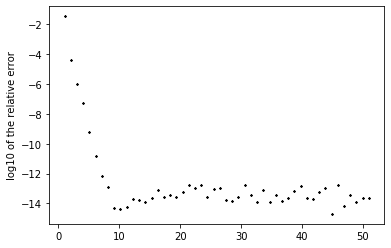

In [36]:
k_det = np.linspace(1,size+1,size)
plt.plot(k_det,relative_error_2,'k*',markersize=2)
plt.ylabel('log10 of the relative error') 
plt.show()